In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import pickle
from time import ctime
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core.base import Constraint as pyo_constraint
from pyomo.core.base import Var as pyo_vars

### Data processing functions

In [3]:
def load_input_data(input_data):
    """
    Return input data as numpy arrays in a dictionary.
    """

    # parse the input
    lines = input_data.split('\n')

    firstLine = lines[0].split()
    num_facilities = int(firstLine[0])
    num_customers = int(firstLine[1])
    
    data_dict = {}

    facility_cost_array = np.zeros(num_facilities)
    facility_capacity_array = np.zeros(num_facilities)
    facility_location_array = np.zeros((num_facilities, 2))
    for i in range(num_facilities):
        line = lines[i + 1]
        parts = line.split()
        facility_cost_array[i] = parts[0]
        facility_capacity_array[i] = parts[1]
        facility_location_array[i,:] = np.array([parts[2], parts[3]])
        
    data_dict['facility_cost_array'] = facility_cost_array
    data_dict['facility_capacity_array'] = facility_capacity_array
    data_dict['facility_location_array'] = facility_location_array

    customer_demand_array = np.zeros(num_customers)
    customer_location_array = np.zeros((num_customers, 2))
    for i in range(num_customers):
        line = lines[i + 1 + num_facilities]
        parts = line.split()
        customer_demand_array[i] = parts[0]
        customer_location_array[i,:] = np.array([parts[1], parts[2]])
        
    data_dict['customer_demand_array'] = customer_demand_array
    data_dict['customer_location_array'] = customer_location_array
    
    return data_dict

In [90]:
input_file = open('data/fl_3_1','r').read()

In [91]:
data_dict = load_input_data(input_file)

In [37]:
data_dict

{'facility_cost_array': array([100., 100., 100.]),
 'facility_capacity_array': array([100., 100., 500.]),
 'facility_location_array': array([[1065., 1065.],
        [1062., 1062.],
        [   0.,    0.]]),
 'customer_demand_array': array([50., 50., 75., 75.]),
 'customer_location_array': array([[1397., 1397.],
        [1398., 1398.],
        [1399., 1399.],
        [ 586.,  586.]])}

In [101]:
def get_solution(data_dict, results_dict):
    
    solution = np.zeros(len(data_dict['customer_location_array']))
    for facility, customer_list in results_dict['facility_customers'].items():
        solution[customer_list] = facility
        
    return solution.astype(int)

In [102]:
solution = get_solution(data_dict, results_dict)
solution

array([0, 0, 1, 2])

In [76]:
def prepare_output_data(data_dict, results_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """
    
    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)
        
    solution = get_solution(data_dict, results_dict)
    
    output_data = str(results_dict['objective_value']) + ' ' + optimal + '\n'
    output_data += ' '.join(map(str, solution.astype(int)))
    
    return output_data

In [152]:
prepare_output_data(data_dict, results_dict, is_provably_optimal=False)

In [7]:
def create_facility_customer_dist_matrix(data_dict):
    
    """
    Distance matrix between facilities (rows) and customers (columns)
    """
    
    return cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])

In [94]:
facility_customer_dist_matrix = cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

In [100]:
solution

array([0., 0., 1., 2.])

In [103]:
facility_customer_dist_matrix[solution, np.arange(4)]

array([469.51890271, 470.93311627, 476.58997052, 828.72914755])

In [97]:
np.arange(4)

array([0, 1, 2, 3])

In [99]:
facility_customer_dist_matrix[[1,2],[2,3]]

array([476.58997052, 828.72914755])

### Write a greedy algorithm to solve

In [19]:
def greedy_solution(data_dict, facility_customer_dist_matrix=None):
    
    """
    Greedy algorithm. Simply finds the customer closest to any facility with enough
    capacity and assigns them to that facility, then moves to the next closest, etc. 
    """
    
    def get_k_smallest_indicies(arr, k):
        
        """Helper function"""
    
        flat_indices = np.argpartition(arr.ravel(), k-1)[:k]
        row_indices, col_indices = np.unravel_index(flat_indices, arr.shape)
        min_elements = arr[row_indices, col_indices]
        min_elements_order = np.argsort(min_elements)
        row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

        return [[row_indices[i], col_indices[i]] for i in range(len(col_indices))]
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix_copy = create_facility_customer_dist_matrix(data_dict)
    else:
        facility_customer_dist_matrix_copy = facility_customer_dist_matrix.copy()
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    customers_not_used = np.arange(num_customers)
    mins_to_choose_add = 5
    mins_to_choose = 5
    while len(customers_not_used) > 0:
        print(customers_not_used)
        customer_fits = False
        #facility_customer_dist_matrix_copy = facility_customer_dist_matrix_copy[:, customers_not_used]
        counter = 0
        while not customer_fits:
            if counter > mins_to_choose-1:
                mins_to_choose += mins_to_choose_add
            smallest_indicies = get_k_smallest_indicies(facility_customer_dist_matrix_copy[:, customers_not_used], 
                                                        min(mins_to_choose, 
                                                            facility_customer_dist_matrix_copy[:, customers_not_used].size-1))
            #print(smallest_indicies)
            #print(counter)
            #print(mins_to_choose)
            facility, customer = smallest_indicies[counter][0], smallest_indicies[counter][1]
            cost = facility_customer_dist_matrix_copy[:, customers_not_used][facility, customer]
            demand = customer_demand_array[customer]
            #print(cost)
            if facility_remaining_capacity[facility] >= demand:
                facility_remaining_capacity[facility] -= demand
                transport_costs += cost
                if facility not in facility_customers.keys():
                    facility_customers[facility] = [customer]
                    fixed_costs += facility_cost_array[facility]
                else:
                    facility_customers[facility].append(customer)
                customers_not_used = customers_not_used[customers_not_used!=customer]
                customer_fits = True
            else:
                counter += 1
            
    return facility_customers
            
            
        

In [26]:
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

In [9]:
def greedy_solution(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    
    customer_ordering = np.argsort(np.min(facility_customer_dist_matrix, axis=0))
    
    for customer in customer_ordering:
        closest_facility_indexes = np.argsort(facility_customer_dist_matrix[:, customer])
        customer_demand = customer_demand_array[customer]
        customer_allocated = False
        counter = 0
        #print('customer: ' + str(customer))
        #print('customer_demand: ' + str(customer_demand))
        while not customer_allocated:
            facility = closest_facility_indexes[counter]
            #print('facility: ' + str(facility))
            #print('facility capacity: ' +str(facility_remaining_capacity[facility]))
            if facility in facility_customers.keys():
                if facility_remaining_capacity[facility] >= customer_demand:
                    facility_customers[facility].append(customer)
                    facility_remaining_capacity[facility] -= customer_demand
                    transport_costs += facility_customer_dist_matrix[facility, customer]
                    customer_allocated = True
                    #print('used facility ' + str(facility))
                else:
                    counter += 1
            else:
                facility_customers[facility] = [customer]
                facility_remaining_capacity[facility] -= customer_demand
                fixed_costs += facility_cost_array[facility]
                transport_costs += facility_customer_dist_matrix[facility, customer]
                customer_allocated = True
                #print('used facility ' + str(facility))
        #print(' ')
        
    out_dict = {}
    out_dict['facility_customers'] = facility_customers
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = False
        
    return out_dict
                

In [92]:
results_dict = greedy_solution(data_dict)
results_dict

{'facility_customers': {0: [0, 1], 1: [2], 2: [3]},
 'fixed_costs': 300.0,
 'transport_costs': 2245.771137048475,
 'objective_value': 2545.771137048475,
 'is_optimal': False}

### Write and solve the optimisation model with Pyomo and CBC/CPLEX

In [11]:
def objective_function(model):
    
    return sum(model.fixed_costs[f] * model.x[f] for f in model.F) \
         + sum(sum(model.transport_costs[f, c] * model.y[f, c] for f in model.F) for c in model.C)

In [13]:
def constraint_open_facilities(model, f, c):
    
    return model.y[f, c] <= model.x[f]

def constraint_customer_assigned(model, c):
    
    return sum(model.y[f, c] for f in model.F) == 1

def constraint_capacity(model, f):
    
    return sum(model.demands[c] * model.y[f, c] for c in model.C) <= model.capacities[f]

In [14]:
def build_model(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in range(len(facility_cost_array))])
    model.C = pyo.Set(initialize=[c for c in range(len(customer_demand_array))])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={counter: element for counter, element in 
                                              enumerate(facility_cost_array)}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(counter_1, counter_2): facility_customer_dist_matrix[counter_1, counter_2] 
                                                  for counter_1 in range(len(facility_cost_array))
                                                  for counter_2 in range(len(customer_demand_array))}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={counter: element for counter, element in 
                                          enumerate(customer_demand_array)}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={counter: element for counter, element in 
                                             enumerate(facility_capacity_array)}, default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    return model

In [15]:
def solve_model_milp(model, solver_name, solver_path, timeout_time=120, ratio_gap=0.01, show_working=True):
    
    print('Run start time: ' + str(ctime()))
    
    # Use CPLEX on the NEOS server
    if solver_name == 'cplex':
        manager = pyo.SolverManagerFactory('neos')
        opt_settings = SolverFactory(solver_name)
        opt_settings.set_options('mipgap=' + str(ratio_gap))
        opt_settings.set_options('timelimit=' + str(timeout_time))
        opt_settings.set_options('mipdisplay=' + str(3))
        opt_settings.set_options('nodefile=' + str(2))
        opt_settings.set_options('treememory=' + str(10000))
        results = manager.solve(model, opt=opt_settings, keepfiles=True)
        
    elif solver_name == 'cbc':
        opt_settings = SolverFactory(solver_name, executable=solver_path)
        opt_settings.set_options('sec=' + str(timeout_time))
        opt_settings.set_options('ratioGap=' + str(ratio_gap))
        results = opt_settings.solve(model, tee=show_working)
        
    else:
        raise ValueError(f'Solver {solver_name} not supported')
        
    print('Run finish time: ' + str(ctime()))        
    
    return model, results

In [64]:
model_instance = build_model(data_dict)

In [69]:
model_instance, results_instance = solve_model_milp(model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=True)

Run start time: Tue Feb  4 17:06:56 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 120 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmphp4ulhf5.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmphp4ulhf5.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 120
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 161000 (-1) rows, 160200 (-1) columns and 640000 (-1) elements
Statistics for presolved model
Original problem has 160200 integers (160200 of which binary)
Presolved problem has 160200 integers (160200 of which binary)
==== 0 zero objective 160200 different
==== absolute objective values 160200 different
==== for integers 0 zero objective 160200 different
==== for integers absolute objective values 160200 different
===== end objective counts


Prob

Cbc0014I Cut generator 7 (ZeroHalf) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is -100
Cbc0020I Exiting on maximum time
Cbc0005I Partial search - best objective 4813323 (best possible 4673354.8), took 101 iterations and 0 nodes (117.81 seconds)
Cbc0035I Maximum depth 0, 0 variables fixed on reduced cost
Cuts at root node changed objective from 4.66696e+06 to 4.67335e+06
Probing was tried 1 times and created 0 cuts of which 0 were active after adding rounds of cuts (8.914 seconds)
Gomory was tried 1 times and created 10 cuts of which 0 were active after adding rounds of cuts (1.822 seconds)
Knapsack was tried 1 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.403 seconds)
Clique was tried 1 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.012 seconds)
MixedIntegerRounding2 was tried 1 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.252 seconds)
Fl

In [33]:
model_instance, results_instance = solve_model_milp(model_instance, 'cplex', 
                                                    'neos',
                                                    timeout_time=300, ratio_gap=0, show_working=True)

Run start time: Tue Feb  4 15:59:40 2020
Run finish time: Tue Feb  4 16:01:16 2020


In [18]:
def get_results_dict(model, results, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    out_dict = {'facility_customers':{}}
    fixed_costs = 0
    transport_costs = 0
    
    for tup, val in model.y.get_values().items():
        facility, customer = tup[0], tup[1]
        if val == 1:
            if facility not in out_dict['facility_customers']:
                out_dict['facility_customers'][facility] = [customer]
                fixed_costs += data_dict['facility_cost_array'][facility]
            else:
                out_dict['facility_customers'][facility].append(customer)
            transport_costs += facility_customer_dist_matrix[facility, customer]
            
    if str(list(results['Solver'])[0]['Termination condition']) == 'optimal':
        is_optimal = True
    else:
        is_optimal = False
            
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = is_optimal
        
    return out_dict

In [71]:
results_dict = get_results_dict(model_instance, results_instance, data_dict)
results_dict

{'facility_customers': {0: [1, 124, 154, 295, 380, 394, 424, 508, 635, 789],
  2: [88, 233, 287, 556, 583, 666, 714],
  3: [34, 57, 62, 349, 443, 498, 533, 615, 632],
  4: [52, 133, 149, 216, 276, 628, 710, 726],
  6: [8, 128, 131, 237, 442, 566, 625],
  7: [262, 445, 452, 462, 525, 537, 622, 674, 767],
  9: [4, 25, 47, 167, 181, 202, 261, 529, 535, 732, 758],
  16: [337, 720, 775],
  18: [39, 51, 70, 90, 139, 310, 450, 486],
  21: [208, 278, 303, 456, 530, 679, 718],
  22: [157, 176, 257, 335, 341, 466, 478, 523, 796],
  24: [7, 113, 327, 331, 423, 548, 590, 746, 790],
  25: [66, 67, 213, 336, 362, 476, 477],
  26: [63, 195, 313, 316, 459, 473, 634, 676, 784],
  28: [35, 114, 212, 223, 265, 311, 320, 667, 727],
  30: [49, 79, 91, 115, 269, 338, 493, 687, 751],
  32: [121, 145, 160, 165, 175, 232, 575, 630, 778],
  33: [5, 95, 117, 624, 626, 781, 786],
  34: [112, 225, 372, 461, 463, 547, 573, 579, 633, 700, 733],
  35: [12, 18, 45, 196, 253, 339, 359, 371, 668],
  36: [482, 550, 680, 

In [114]:
def get_objective_value_from_solution(solution, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    
    transport_costs = facility_customer_dist_matrix[solution, 
                                                    np.arange(len(data_dict['customer_location_array']))].sum()
    
    fixed_costs = data_dict['facility_cost_array'][np.unique(solution)].sum()
    
    return transport_costs + fixed_costs

In [115]:
get_objective_value_from_solution(solution, data_dict)

2545.771137048475

In [21]:
def visualise_solution(data_dict, results_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Fixed cost: ' + str(int(results_dict['fixed_costs'])) \
                 + '   Transport costs: ' + str(int(results_dict['transport_costs'])))
    ax.scatter(customer_location_array[:, 0], customer_location_array[:, 1],  marker='+')
    ax.scatter(facility_location_array[:, 0], facility_location_array[:, 1],  marker='H')
    ax.axis('equal')
    
    for facility in range(len(facility_cost_array)):
        facility_location = facility_location_array[facility]
        if facility in results_dict['facility_customers']:
            for customer in results_dict['facility_customers'][facility]:
                customer_location = customer_location_array[customer]
                ax.annotate("",
                            xy=facility_location, xycoords='data',
                            xytext=customer_location, 
                            textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3"))
    
    #plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


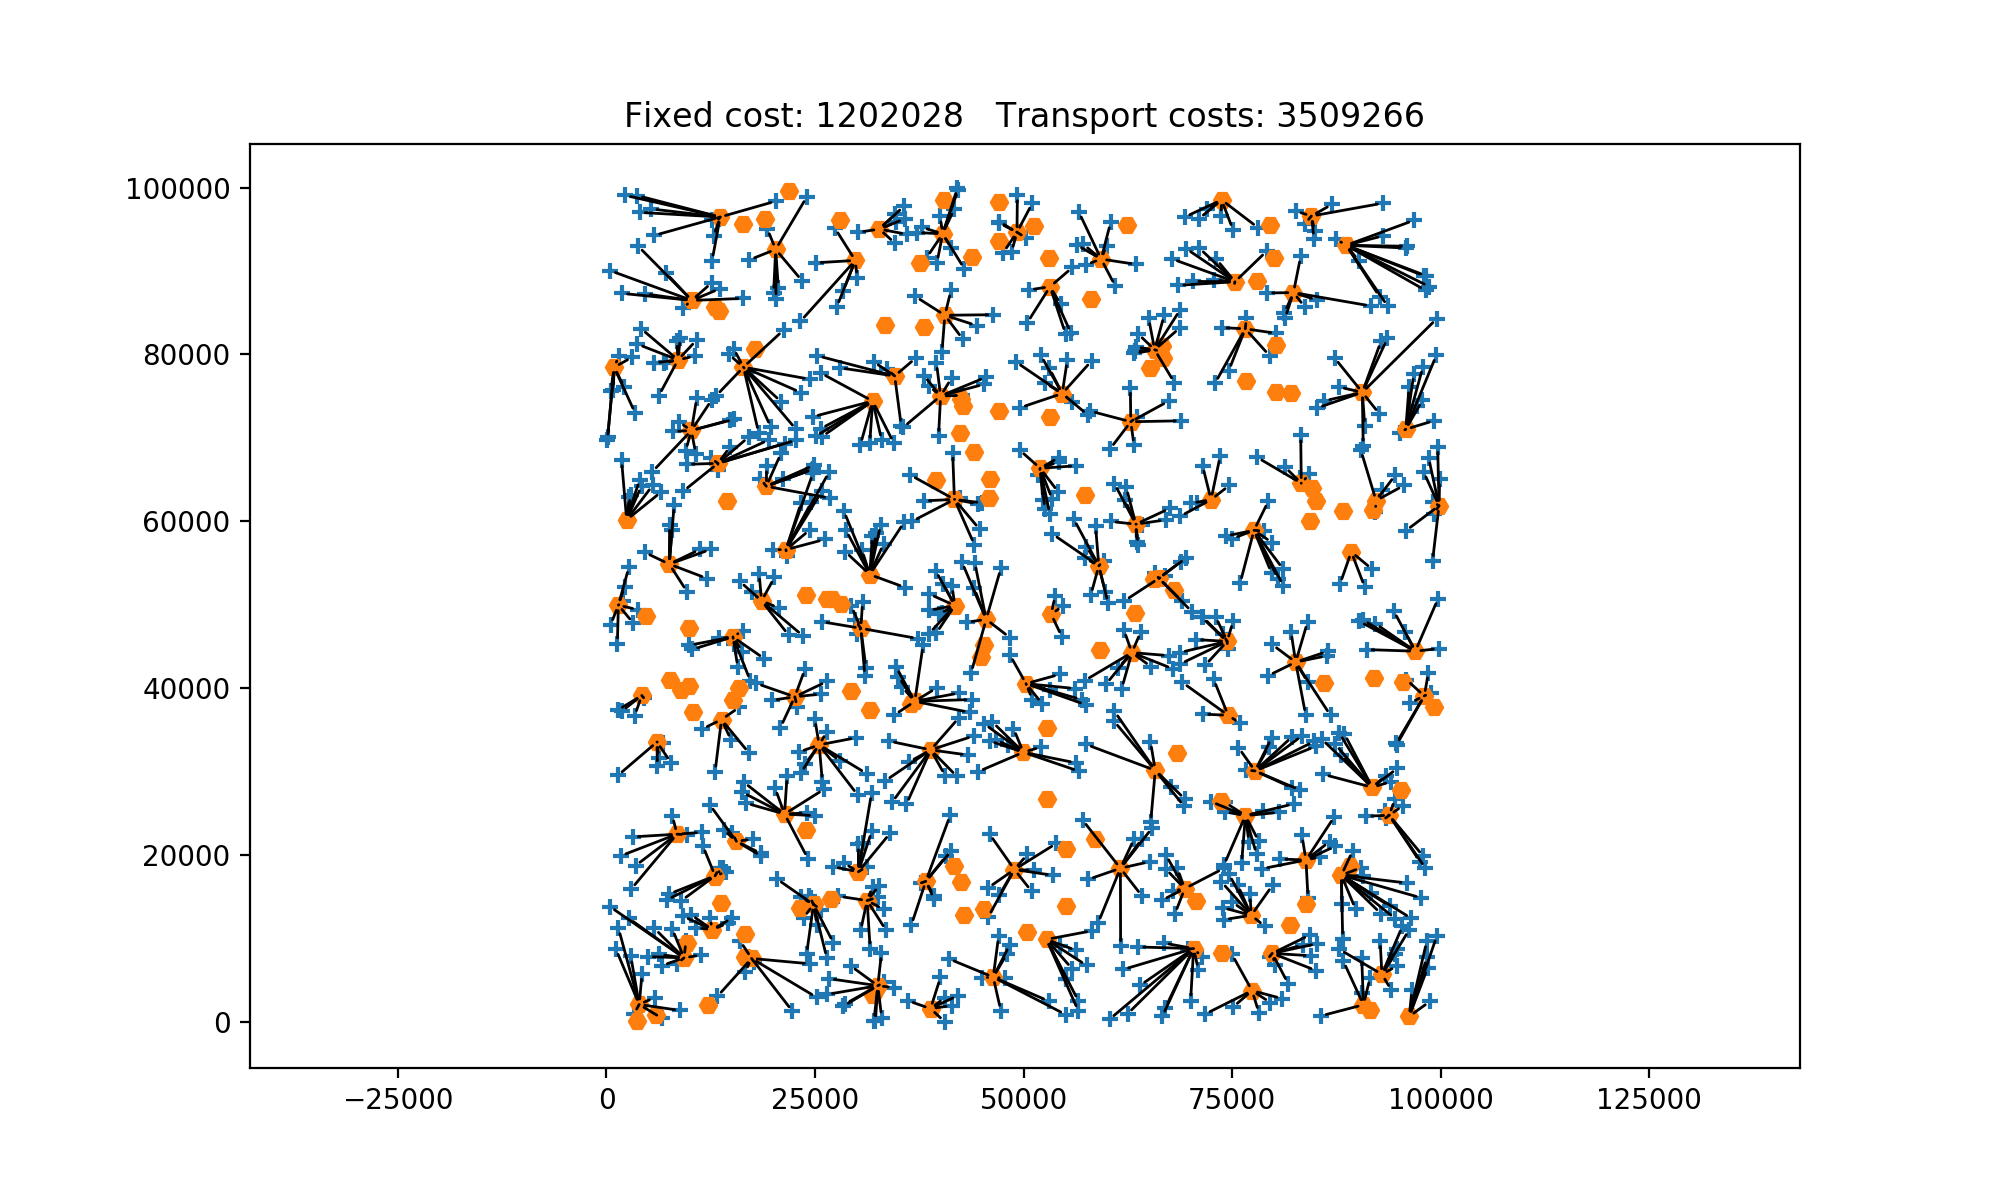

In [35]:
%matplotlib notebook
visualise_solution(data_dict, results_dict)

<IPython.core.display.Javascript object>


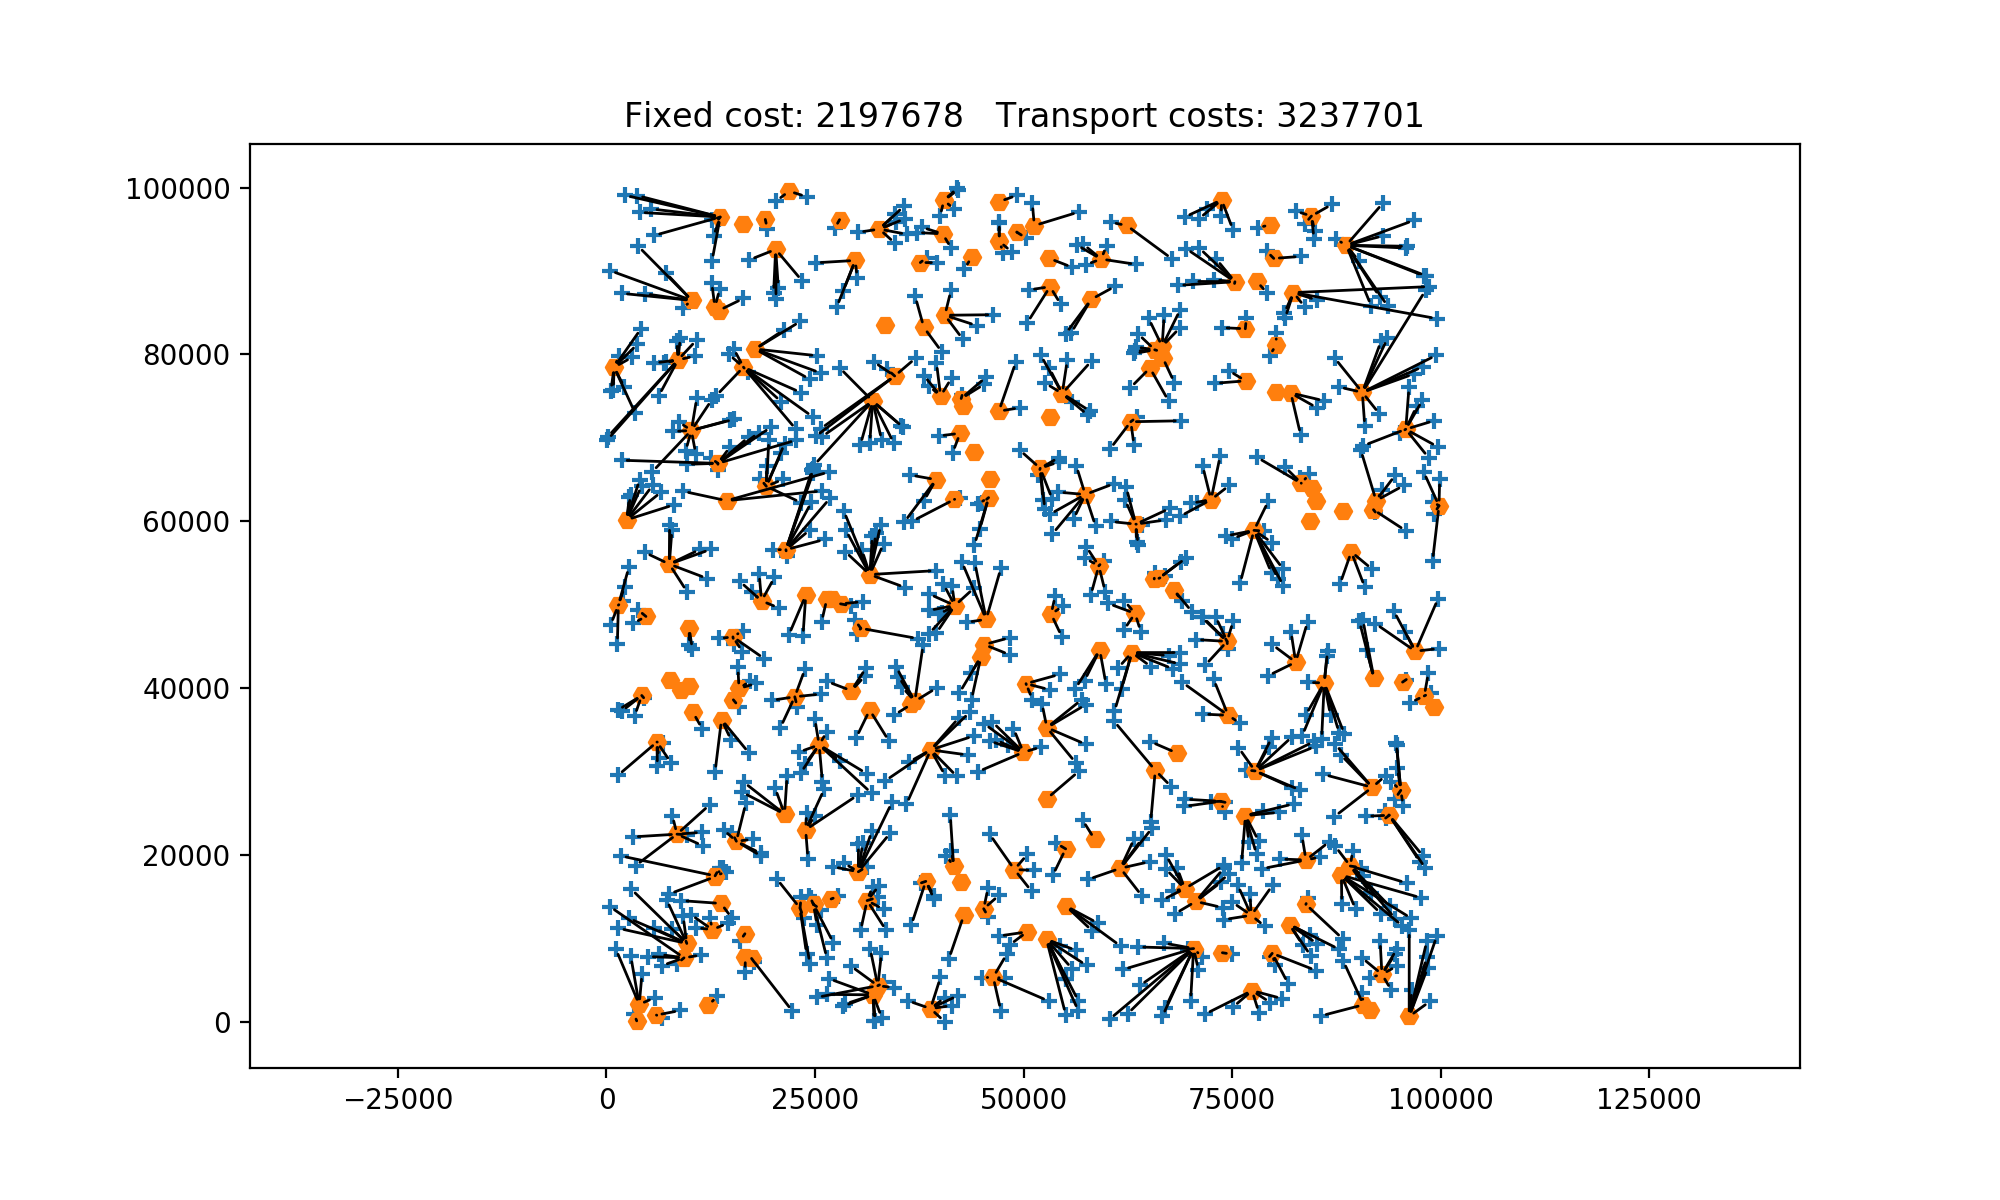

In [74]:
%matplotlib notebook
visualise_solution(data_dict, results_dict)

### Try a Large Neighbourhood Search algorithm

For a neighbourhood, pick a random part of the map (split it into a grid) and unassign all customers in the grid, as well as all facilities serving these customers and all customers served by those facilities. Solve this subproblem with a IP.

In [42]:
def get_customer_map_corners(customer_location_array):
    
    top_left = [customer_location_array[:,0].min(), customer_location_array[:,1].max()]
    bottom_left = [customer_location_array[:,0].min(), customer_location_array[:,1].min()]
    bottom_right = [customer_location_array[:,0].max(), customer_location_array[:,1].min()]
    top_right = [customer_location_array[:,0].max(), customer_location_array[:,1].max()]
    
    out_dict = {
        'top_left': top_left,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right,
        'top_right': top_right
    }
    
    return out_dict

In [146]:
map_corner_dict = get_customer_map_corners(customer_location_array)
map_corner_dict

{'top_left': [114.655, 99922.625],
 'bottom_left': [114.655, 0.0],
 'bottom_right': [99891.6125, 0.0],
 'top_right': [99891.6125, 99922.625]}

In [50]:
def interpolate(v1, v2, interp_points, n):
    
    if v1 > v2:
        return v2 + ((v1-v2)/interp_points)*n
    elif v2 > v1:
        return v1 + ((v2-v1)/interp_points)*n
    else:
        return v1

In [156]:
interpolate(10, 20, 10, 9)

19.0

In [157]:
def get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces,
                     central_width_piece_start_num, central_length_piece_start_num, 
                     width_piece_size = 1, length_piece_size = 1):
    
    width_additional_cells = (width_piece_size-1)/2
    length_additional_cells = (length_piece_size-1)/2
    
    x_left = interpolate(map_corner_dict['bottom_left'][0], 
                         map_corner_dict['bottom_right'][0], 
                         num_width_pieces, max(central_width_piece_start_num - width_additional_cells, 0))
    x_right = interpolate(map_corner_dict['bottom_left'][0], 
                          map_corner_dict['bottom_right'][0], 
                          num_width_pieces, min(central_width_piece_start_num + width_additional_cells + 1, 
                                               num_width_pieces))
    y_bottom = interpolate(map_corner_dict['bottom_left'][1], 
                           map_corner_dict['top_left'][1], 
                           num_length_pieces, max(central_length_piece_start_num - length_additional_cells, 0))
    y_top = interpolate(map_corner_dict['bottom_left'][1], 
                        map_corner_dict['top_left'][1], 
                        num_length_pieces, min(central_length_piece_start_num + length_additional_cells + 1, 
                                               num_length_pieces))
    
    out_dict = {
        'top_left': [x_left, y_top],
        'bottom_left': [x_left, y_bottom],
        'bottom_right': [x_right, y_bottom],
        'top_right': [x_right, y_top]
    }
    
    return out_dict

In [162]:
grid_corners = get_grid_corners(map_corner_dict, 10, 10, 5, 5 , width_piece_size = 3, length_piece_size = 3)
grid_corners

{'top_left': [40025.438, 69945.83750000001],
 'bottom_left': [40025.438, 39969.05],
 'bottom_right': [69958.52525, 39969.05],
 'top_right': [69958.52525, 69945.83750000001]}

In [61]:
def get_customers_in_grid(data_dict, grid_corners):
    
    customer_location_array  = data_dict['customer_location_array']
    
    customer_indexes = np.where((customer_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(customer_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(customer_location_array[:,1] <= grid_corners['top_left'][1])
                               &(customer_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return customer_indexes

In [62]:
get_customers_in_grid(data_dict, grid_corners)

array([ 49,  56,  72,  79,  91, 115, 170, 196, 230, 253, 269, 298, 314,
       371, 404, 414, 418, 493, 518, 569, 574, 656, 662, 706, 747, 751,
       785], dtype=int64)

In [116]:
def get_facilities_in_grid(data_dict, grid_corners):
    
    facility_location_array  = data_dict['facility_location_array']
    
    facility_indexes = np.where((facility_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(facility_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(facility_location_array[:,1] <= grid_corners['top_left'][1])
                               &(facility_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return facility_indexes

In [ ]:
get_facilities_in_grid(get_grid_corners(map_corner_dict, 5, 5, 2, 2))

In [68]:
lns_parameter_dict = {
    'num_width_pieces': 6, 
    'num_length_pieces': 6,
    'iterations': 10
}

In [ ]:
def run_lns(data_dict, lns_parameter_dict, initial_solution = None):
    
    
    """
    Run a LNS where the neighbourhood is made by unassigning all the customers in a particular 
    map cell, unassigning all facilities those customers were assigned to, then unassigning 
    all customers assigned to those facilities.
    The subproblem for the neighbourhood only considers the unassigned customers and the
    facilities that were unassigned + the facilities in the neighbouring map cells.
    """
    
    if initial_solution is None:
        initial_solution_results_dict = greedy_solution(data_dict)
        initial_solution = get_solution(data_dict, initial_solution_results_dict)
    facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    current_solution = initial_solution.copy()
    current_objective = get_objective_value_from_solution(current_solution, data_dict, 
                                                          facility_customer_dist_matrix=facility_customer_dist_matrix)
    best_solution = current_solution.copy()
    best_objective = current_objective
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    num_width_pieces = lns_parameter_dict['num_width_pieces']
    num_length_pieces = lns_parameter_dict['num_length_pieces']
    iterations = lns_parameter_dict['iterations']
    
    map_corner_dict = get_customer_map_corners(customer_location_array)
    
    for iteration in range(iterations):
        # pick a random square on the grid to optimise
        width_piece_num, length_piece_num = np.random.randint(num_width_pieces), np.random.randint(num_length_pieces)
        grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                        width_piece_num, length_piece_num)
        # get the customers to initially unassign, and the facilities they were assigned to,
        # then get all the customers for those facilities to unassign
        # then get all the facilities in the 8 grid cells surrounding the current 
        # grid cell to include in the subproblem
        initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
        facilities_to_unassign = np.unique(current_solution[initial_customers_to_unassign])
        customers_to_unassign = np.where(np.in1d(current_solution, initial_facilities_to_unassign))[0]
        wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                              width_piece_num, length_piece_num,
                                              width_piece_size = 3, length_piece_size = 3)
        facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
        # calculate the new capacities for the facilities in the wider grid 
        # that still have some customers assigned
        temp_data_dict = data_dict.copy()
        

In [165]:
t = data_dict.copy()
t

{'facility_cost_array': array([100., 100., 100.]),
 'facility_capacity_array': array([100., 100., 500.]),
 'facility_location_array': array([[1065., 1065.],
        [1062., 1062.],
        [   0.,    0.]]),
 'customer_demand_array': array([50., 50., 75., 75.]),
 'customer_location_array': array([[1397., 1397.],
        [1398., 1398.],
        [1399., 1399.],
        [ 586.,  586.]])}